## 12.03.2025

This notebook is based on `01-read-slow-wave-example-v3.ipynb`. It is used to do the data analysis of the full night sleep data `EPISL_02_W2_EEG_FiltDwn_05to30Hz.mat`.

In [1]:
# Read the .mat file

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

folder_name = "/home/gs/code/swift-eeg/data/data_EPISL/EPISL_01_W1/EPISL_02_W2/"
file_name = "EPISL_02_W2_EEG_FiltDwn_05to30Hz.mat"

# Load the .mat file
mat_data = scipy.io.loadmat(folder_name + file_name)

In [ ]:
mat_data.keys()

In [2]:
eeg = mat_data["EEG"]

# Extract the EEG data
eeg_data = eeg[0, 0]["data"]  # Shape: (129, 3595419)


# See the keys in eeg[0, 0]
eeg_keys = eeg[0, 0].dtype.names

In [ ]:
eeg_chanlocs = eeg[0,0]["chanlocs"] # shape: (1, 129)



Extract between 3 - 5 s (the grey area) for future slow wave analysis

The data is already band passed between 0.5 and 35Hz.

In [3]:
F = eeg_data

/tmp/ipykernel_543962/2263659403.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


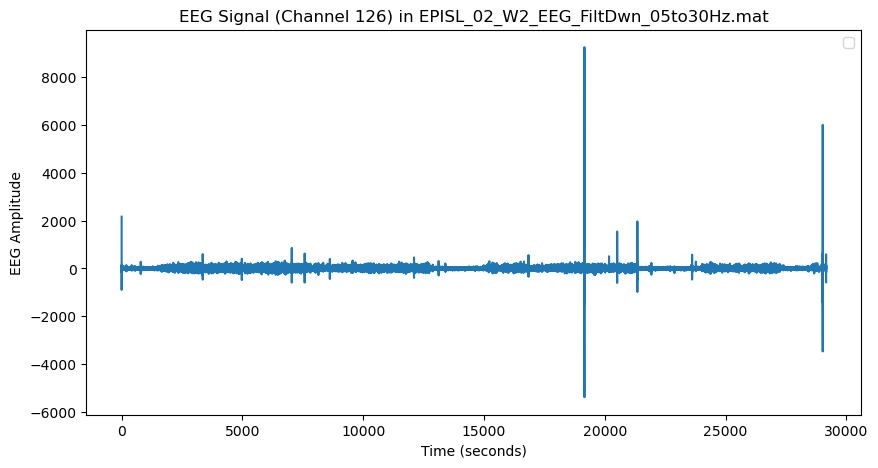

In [4]:
# TODO: between 2 and 3.5 s

# Sampling rate
fs = 125  # Hz
time = np.arange(F.shape[1]) / fs  # Convert sample indices to seconds

# Select a specific channel for visualization (e.g., channel 0)
channel_idx = 126
eeg_signal = F[channel_idx, :]

# Plot EEG signal
plt.figure(figsize=(10, 5))
plt.plot(time, eeg_signal)
# plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2 sec")
# plt.axvspan(3, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Amplitude")
plt.title(f"EEG Signal (Channel {channel_idx}) in {file_name}")
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(10, 20))
for i in range(129):
    plt.plot(
        time, F[i, :] + i * 50, color="black", linewidth=0.5
    )  # Offset for visibility

plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
plt.axvspan(3, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
for i in range(129):
    plt.plot(time, F[i, :], color="black", linewidth=0.5)  # Offset for visibility

plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
plt.axvspan(3, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

the data samples are referenced to the channel 129 (Cz) and need to be re-referenced to the average of the mastoid channels (channel 57 + channel 100) 

EEG - mean(EEG.ch57, EEG.ch100)

In [5]:
eeg_mastoid_channels = np.mean(F[[56, 99]], axis = 0)

# Re-reference all channels
F_referenced = F - eeg_mastoid_channels  # Broadcasting: (129, 626) - (626,)



In [ ]:
# Visualize the mastoid referenced EEG data

plt.figure(figsize=(10, 20))
for i in range(F_referenced.shape[0]):
    plt.plot(
        time, F_referenced[i, :] + i * 50, color="black", linewidth=0.5
    )  # Offset for visibility

plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
plt.axvspan(3, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

An Independent Component Analysis (ICA) procedure was also used to reduce ocular, muscular, and electrocardiograph artifacts using EEGLAB routines

In [6]:
import mne

# Artifact rejection and interpolation using MNE
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")  # 129-channel system

info = mne.create_info(ch_names=montage.ch_names, sfreq=fs, ch_types="eeg")
raw = mne.io.RawArray(F_referenced, info)
raw.set_montage(montage)


Creating RawArray with float64 data, n_channels=129, n_times=3645543
    Range : 0 ... 3645542 =      0.000 ... 29164.336 secs
Ready.


<RawArray | 129 x 3645543 (29164.3 s), ~3.50 GB, data loaded>

In [ ]:
# Apply ICA to remove ocular, muscular, and ECG artifacts
ica = mne.preprocessing.ICA(n_components=30, random_state=97, max_iter="auto")
ica.fit(raw)


In [ ]:
ica.plot_components()


Since the system lacks explicit EOG channels, you can use the following EEG electrodes to estimate EOG activity:

    Vertical EOG (vEOG) → Detects Blinks & Up-Down Movements
        Use Electrodes: 125 (Above the eye) & 126 (Below the eye)
        These electrodes capture blinks and vertical saccades.

    Horizontal EOG (hEOG) → Detects Left-Right Movements
        Use Electrodes: 128 (Left outer eye) & 127 (Right outer eye)
        These electrodes capture horizontal eye movements.

In [ ]:
# Create a Vertical EOG Channel

mne.set_bipolar_reference(raw, anode='E125', cathode='E126', ch_name='VEOG')

# Create a Horizontal EOG Channel

mne.set_bipolar_reference(raw, anode='E128', cathode='E127', ch_name='HEOG')



In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name='VEOG')
eog_inds, scores = ica.find_bads_eog(raw)  # Find EOG artifacts
ica.plot_scores(scores)  # Show EOG component scores

In [7]:

# Detect EOG and ECG artifacts automatically
# eog_indices, _ = ica.find_bads_eog(raw, threshold=3.0)
# ecg_indices, _ = ica.find_bads_ecg(raw, threshold=3.0)

# Remove artifact components
# ica.exclude = eog_indices + ecg_indices
# raw_cleaned = ica.apply(raw)

raw_cleaned = raw


these channels should be excluded:
excluded_channels = [43 48 49 56 63 68 73 81 88 94 99 107 113 119 120 125 126 127 128];

In [8]:
channels = np.array(range(129))

excluded_channels = np.array(
    [43, 48, 49, 56, 63, 68, 73, 81, 88, 94, 99, 107, 113, 119, 120, 125, 126, 127, 128]
) # Done: - 1 

excluded_channels = np.array(
    [43, 48, 49, 56, 63, 68, 73, 81, 88, 94, 99, 107, 113, 119, 120, 125, 126, 127, 128]
) - 1

# Remove 72 neck/face electrodes, retaining 185 scalp channels
# Assuming predefined scalp electrodes list

scalp_channels = np.setdiff1d(
    channels, excluded_channels
)   

scalp_channels


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  43,  44,  45,  46,  49,  50,  51,  52,  53,  54,
        56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  68,  69,  70,
        71,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,  84,  85,
        86,  88,  89,  90,  91,  92,  94,  95,  96,  97,  99, 100, 101,
       102, 103, 104, 105, 107, 108, 109, 110, 111, 113, 114, 115, 116,
       117, 120, 121, 122, 123, 128])

In [9]:
raw_cleaned.pick(scalp_channels)


<RawArray | 110 x 3645543 (29164.3 s), ~2.99 GB, data loaded>

In [10]:
# Final preprocessed data

F_preprocessed = raw_cleaned.get_data()  # shape: (110, 3645543)

In [11]:
F_preprocessed.shape

(110, 3645543)

In [ ]:
plt.figure(figsize=(10, 20))
for i in range(F_preprocessed.shape[0]):
    plt.plot(
        time, F_preprocessed[i, :] + i * 50, color="black", linewidth=0.5
    )  # Offset for visibility

plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
plt.axvspan(3, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

In [ ]:
F_preprocessed = F_preprocessed[:, -250:] # Shape: (110, 250)



In [ ]:
time = np.arange(F_preprocessed.shape[1]) / fs + 3

In [ ]:
F_preprocessed.shape

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(F_preprocessed.shape[0]):
    plt.plot(
        time, F_preprocessed[i, :], color="black", linewidth=0.5
    )  # Offset for visibility

# plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
# plt.axvspan(3.5, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

Specifically, a negative-going signal envelope was calculated by
selecting the fifth most negative sample across all selected
channels  (Siclari et al., 2014; Bernardi et al., 2016; the four most
negative electrodes were discarded to avoid including potential
residual high amplitude oscillations of artifactual origin). 

In [12]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Assume F_preprocessed is already available (shape: 185 channels x samples)
fs = 125  # Sampling frequency (Hz)
epoch_length = 20  # seconds
samples_per_epoch = fs * epoch_length  # Total samples in one epoch


# 1. Compute the Negative-Going Signal Envelope
def compute_negative_envelope(F_preprocessed):
    """
    Compute the negative-going signal envelope by selecting the
    5th most negative sample across all channels at each time point.
    """
    sorted_F = np.sort(F_preprocessed, axis=0)  # Sort EEG values per timepoint
    neg_envelope = sorted_F[4, :]  # Select the 5th most negative value
    return neg_envelope


neg_envelope = compute_negative_envelope(F_preprocessed)  # neg_envelop shape = (250, )

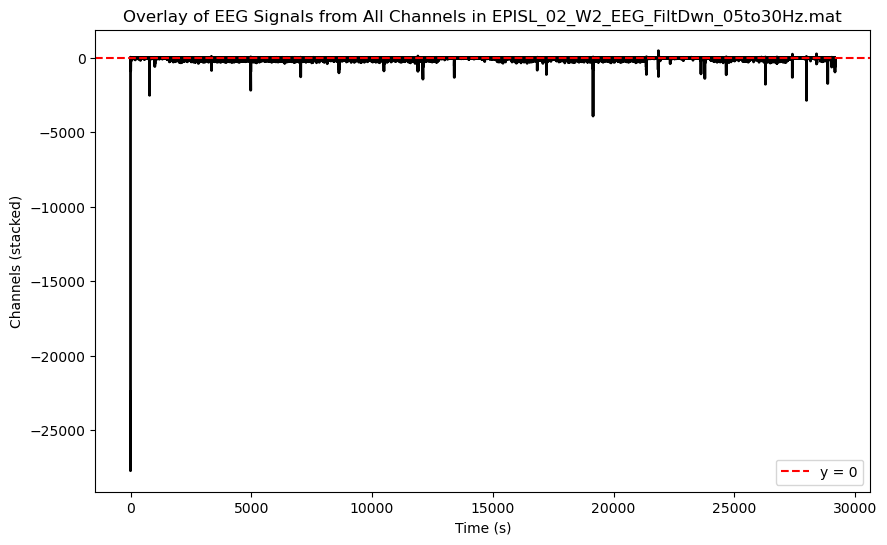

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(time, neg_envelope, color="black", linewidth=2)
# plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.axhline(
    y=0, color="red", linestyle="--", linewidth=1.5, label="y = 0"
)  # Add horizontal line at y = 0
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
# plt.axvspan(3.5, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

In [ ]:
# Plot Slow Waves
plt.figure(figsize=(10, 6))

for i in range(F_preprocessed.shape[0]):
    plt.plot(
        np.arange(len(neg_envelope)) / fs + 3,
        F_preprocessed[i, :],
        color="black",
        linewidth=0.5,
    )  # Offset for visibility


plt.plot(
    np.arange(len(neg_envelope)) / fs + 3,
    neg_envelope,
    label="Negative Envelope",
    color="red",
)


plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Detected Slow Waves on Negative Envelope in {file_name}")
plt.legend()
plt.show()

The resulting signal underwent broadband filtering (0.5–40 Hz, stop-band at 0.1 Hz and 60 Hz)

The negative-going envelope is **not a single EEG channel**, but rather a **composite signal** derived from multiple channels (e.g., taking the 5th most negative sample). Even though it is already a processed signal, it still contains:
- **Residual low-frequency drift**, which could distort slow-wave detection.
- **High-frequency noise**, which could create spurious zero-crossings.
- **Power-line interference**, which can introduce artifacts.

Applying the **broadband filtering ensures that the extracted envelope remains within the physiologically relevant range (0.5–40 Hz)** for slow-wave activity while minimizing unwanted distortions.

In [14]:
# Apply Broadband Filtering (0.5–40 Hz)

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)


neg_envelope_filtered = bandpass_filter(neg_envelope)  # shape = (250, )

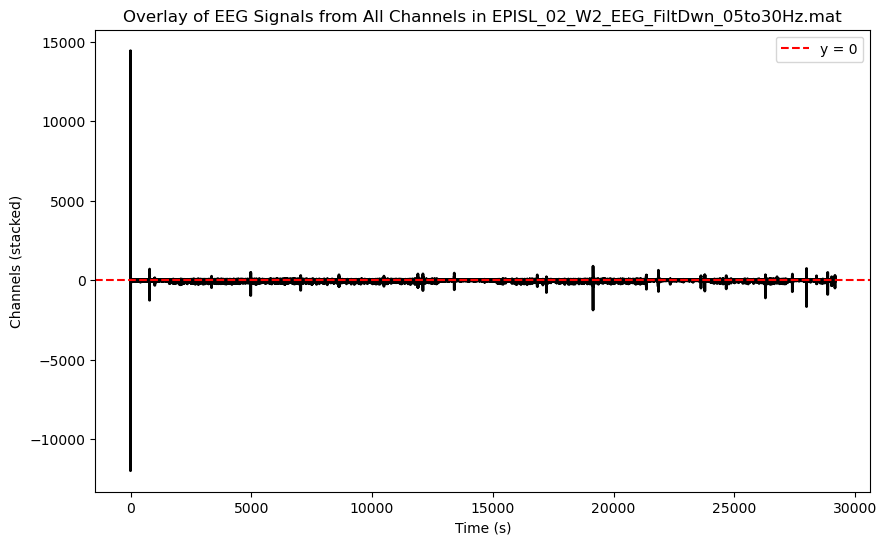

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(time, neg_envelope_filtered, color="black", linewidth=2)
# plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.axhline(
    y=0, color="red", linestyle="--", linewidth=1.5, label="y = 0"
)  # Add horizontal line at y = 0
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
# plt.axvspan(3.5, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

In [16]:
# Notch filter design (to remove 60 Hz and 0.1 Hz) , stop-band at 0.1 Hz & 60 Hz)

def notch_filter(data, freq, fs, quality=30):
    nyquist = 0.5 * fs
    notch_freq = freq / nyquist
    b, a = signal.iirnotch(notch_freq, quality)
    return signal.filtfilt(b, a, data)

notch_60 = 50  # Powerline interference # Done: change the stop band 50 Hz
notch_01 = 0.1  # Ultra-low-frequency drift


# Apply notch filters at 0.1 Hz and 60 Hz
neg_envelope_filtered = notch_filter(neg_envelope_filtered, notch_01, fs)
neg_envelope_filtered = notch_filter(neg_envelope_filtered, notch_60, fs)

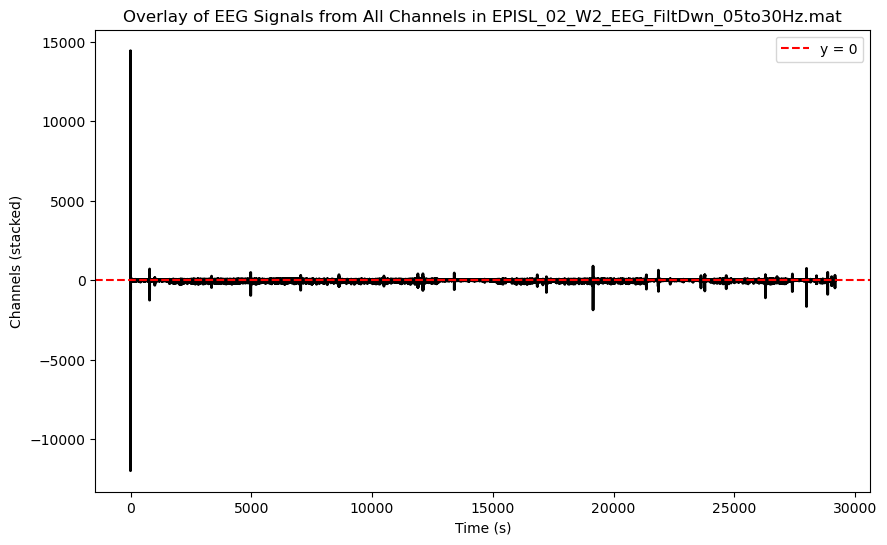

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(time, neg_envelope_filtered, color="black", linewidth=2)
# plt.axvline(x=2, color="r", linestyle="--", label="Stimulation at 2s")
plt.axhline(
    y=0, color="red", linestyle="--", linewidth=1.5, label="y = 0"
)  # Add horizontal line at y = 0
plt.xlabel("Time (s)")
plt.ylabel("Channels (stacked)")
# plt.axvspan(3.5, 5, color="gray", alpha=0.3, label="Slow wave period")
plt.title(f"Overlay of EEG Signals from All Channels in {file_name}")
plt.legend()
plt.show()

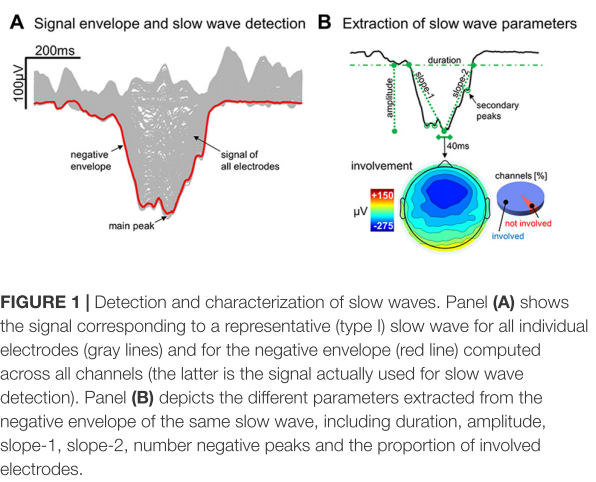

duration (time between zero-crossings [s]), amplitude
of the maximum negative-peak [µV], number of negative peaks,
slope-1 (between the first zero-crossing and the maximum
negative peak [µV/s]), slope-2 (between the maximum negative
peak and the second zero-crossing [µV/s]), and involvement
(mean EEG signal calculated across all electrodes in a 40 ms
window centered on the wave peak [µV]). Only negative
half-waves with a duration between 0.25 s and 1.0 s were
selected for subsequent analyses (full-wave period 0.5–2.0 s).

In [18]:
# Detect Slow Waves Based on Zero-Crossings
def detect_slow_waves(neg_envelope, fs):
    """
    Detect slow waves based on zero-crossings in the negative-going envelope.
    """
    zero_crossings = np.where(np.diff(np.sign(neg_envelope)) != 0)[
        0
    ]  # Negative half-waves
    slow_waves = []

    for i in range(len(zero_crossings) - 1):
        t1, t2 = zero_crossings[i], zero_crossings[i + 1]
        duration = (t2 - t1) / fs  # Time in seconds

        if (
            0.5 <= (t2 - t1) / fs <= 2.0 and np.mean(neg_envelope[t1:t2]) < 0
        ):  # Half-wave duration filter # TODO: The half-wave duration should be optimized?

            neg_peak_idx = np.argmin(neg_envelope[t1:t2]) + t1
            amplitude = neg_envelope[neg_peak_idx]

            if amplitude < 0:

                slope_1 = (amplitude - neg_envelope[t1]) / ((neg_peak_idx - t1) / fs)
                slope_2 = (neg_envelope[t2] - amplitude) / ((t2 - neg_peak_idx) / fs)

                involvement = np.mean(
                    neg_envelope[
                        neg_peak_idx - int(0.02 * fs) : neg_peak_idx + int(0.02 * fs)
                    ]
                )  # 40ms window

                slow_waves.append(
                    {
                        "duration": duration,
                        "amplitude": amplitude,
                        "neg_peak_idx": neg_peak_idx,
                        "slope_1": slope_1,
                        "slope_2": slope_2,
                        "involvement": involvement,
                    }
                )

    return slow_waves

slow_waves = detect_slow_waves(neg_envelope_filtered, fs)

print(len(slow_waves))

804


/home/gs/miniconda3/envs/mne_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


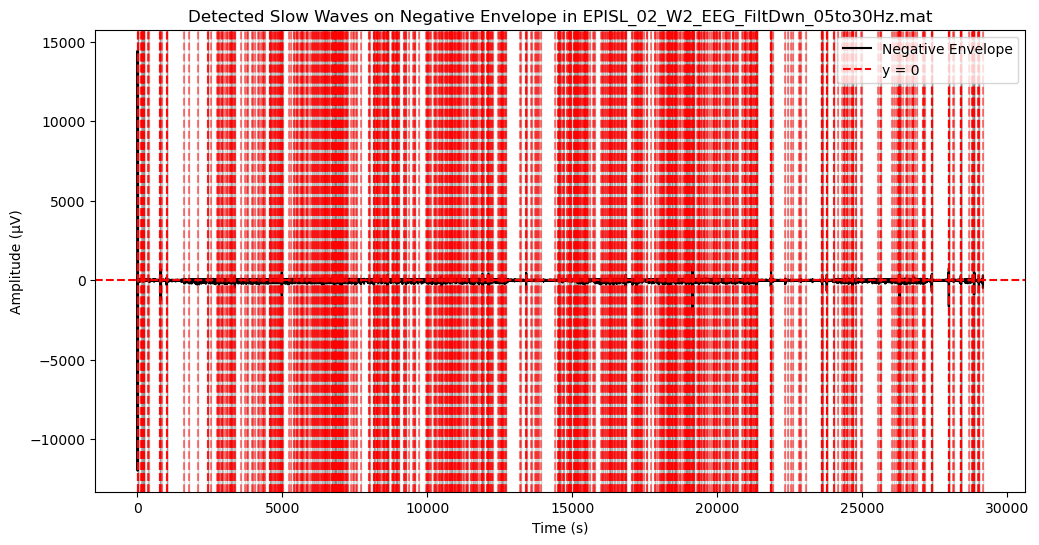

In [20]:
# Plot Slow Waves
plt.figure(figsize=(12, 6))
plt.plot(
    np.arange(len(neg_envelope_filtered)) / fs + 3,
    neg_envelope_filtered,
    label="Negative Envelope",
    color="black",
)

plt.axhline(
    y=0, color="red", linestyle="--", linewidth=1.5, label="y = 0"
)  # Add horizontal line at y = 0

for sw in slow_waves:
    plt.axvline(
        sw["neg_peak_idx"] / fs + 3, color="r", linestyle="--", alpha=0.5
    )  # Mark peak locations
    plt.axvspan(
        sw["neg_peak_idx"] / fs - 0.02 + 3,
        sw["neg_peak_idx"] / fs + 0.02 + 3,
        color="gray",
        alpha=0.3,
    )  # Involvement window

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Detected Slow Waves on Negative Envelope in {file_name}")
plt.legend()
plt.show()

In [ ]:
import os

# Define the output folder and filename
output_folder = "/home/gs/code/swift-eeg/output/data_FT_EEG_FiltDwn/1/"
os.makedirs(output_folder, exist_ok=True)  # Ensure the folder exists

# Define the output file path
output_file = os.path.join(output_folder, f"slow_waves_{file_name}.png")

# Plot Slow Waves
plt.figure(figsize=(12, 6))
plt.plot(
    np.arange(len(neg_envelope_filtered)) / fs,
    neg_envelope_filtered,
    label="Negative Envelope",
    color="black",
)

plt.axhline(
    y=0, color="red", linestyle="--", linewidth=1.5, label="y = 0"
)  # Add horizontal line at y = 0

for sw in slow_waves:
    plt.axvline(
        sw["neg_peak_idx"] / fs, color="r", linestyle="--", alpha=0.5
    )  # Mark peak locations
    plt.axvspan(
        sw["neg_peak_idx"] / fs - 0.02,
        sw["neg_peak_idx"] / fs + 0.02,
        color="gray",
        alpha=0.3,
    )  # Involvement window

    peak_time = sw["neg_peak_idx"] / fs  # Convert index to time

    # Define a small time window for slope visualization (e.g., 50 ms before and after the peak)
    dt = 0.2  # 50 ms before and after the peak
    time_before = peak_time - dt
    time_after = peak_time + dt

    # Compute corresponding amplitude values using the slopes
    amp_peak = neg_envelope_filtered[sw["neg_peak_idx"]]
    amp_before = amp_peak - sw["slope_1"] * dt  # y = y0 + slope * dt
    amp_after = amp_peak + sw["slope_2"] * dt 

    # Plot slope lines before and after the peak
    plt.plot(
        [time_before, peak_time],
        [amp_before, amp_peak],
        color="blue",
        linestyle="-",
        label="Slope 1" if sw == slow_waves[0] else "",
    )
    plt.plot(
        [peak_time, time_after],
        [amp_peak, amp_after],
        color="green",
        linestyle="-",
        label="Slope 2" if sw == slow_waves[0] else "",
    )


plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Detected Slow Waves on Negative Envelope in {file_name}")
plt.legend()
plt.show()

# Save the figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")

In [ ]:
# Plot Slow Waves
plt.figure(figsize=(12, 6))

for i in range(F_preprocessed.shape[0]):
    plt.plot(
        np.arange(len(neg_envelope_filtered)) / fs + 3,
        F_preprocessed[i, :],
        color="black",
        linewidth=0.5,
    )  # Offset for visibility


plt.plot(
    np.arange(len(neg_envelope_filtered)) / fs + 3,
    neg_envelope_filtered,
    label="Negative Envelope",
    color="red",
)

plt.axhline(
    y=-5, color="red", linestyle="--", linewidth=1.5, label="y = -5"
)  # Add horizontal line at y = 0

for sw in slow_waves:
    plt.axvline(
        sw["neg_peak_idx"] / fs + 3, color="r", linestyle="--", alpha=0.5
    )  # Mark peak locations
    plt.axvspan(
        sw["neg_peak_idx"] / fs - 0.02 + 3,
        sw["neg_peak_idx"] / fs + 0.02 + 3,
        color="gray",
        alpha=0.3,
    )  # Involvement window

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Detected Slow Waves on Negative Envelope in {file_name}")
plt.legend()
plt.show()

a ‘‘synchronization score’’ (SS). This parameter was defined as
the relative scalp involvement—expressed as the percentage of
channels showing a negative averaged current value of < −5 µV
in the 40 ms time-window centered on the reference wave
peak—multiplied by the wave mean slope (i.e., the mean of
slope-1 and slope-2 [µV/ms]). 

In [21]:
import numpy as np


def compute_synchronization_score(
    F_preprocessed, neg_peak_idx, slope_1, slope_2, fs=125, window_ms=40, threshold=-5
):
    """
    Compute the Synchronization Score (SS) for a given slow wave.

    Parameters:
        F_preprocessed (numpy array): EEG data (channels x samples)
        neg_peak_idx (int): Index of the slow wave negative peak
        slope_1 (float): First slope (zero-crossing to peak, µV/ms)
        slope_2 (float): Second slope (peak to next zero-crossing, µV/ms)
        fs (int): Sampling frequency in Hz (default 125 Hz)
        window_ms (int): Time window in milliseconds (default 40 ms)
        threshold (float): Amplitude threshold in µV (default -5 µV)

    Returns:
        float: Synchronization Score (SS)
    """
    window_samples = int((window_ms / 1000) * fs) // 2  # Half-window size in samples
    start_idx = max(0, neg_peak_idx - window_samples)
    end_idx = min(F_preprocessed.shape[1], neg_peak_idx + window_samples)

    # Compute mean amplitude in the 40 ms window for each channel
    mean_amplitudes = np.mean(F_preprocessed[:, start_idx:end_idx], axis=1)

    # Count channels where mean amplitude < -5 µV
    involved_channels = np.sum(mean_amplitudes < threshold)

    # Compute scalp involvement percentage
    scalp_involvement = (involved_channels / F_preprocessed.shape[0])

    # Compute mean slope
    mean_slope = (abs(slope_1) + abs(slope_2)) / 2000 # Done: use (abs(slope_1) + abs(slope_2)) / 2 ? # Done: uV/ms

    # Compute Synchronization Score (SS)
    SS = scalp_involvement * mean_slope
    return SS


# Example usage
neg_peak_idx = slow_waves[0]["neg_peak_idx"]  # Example slow wave peak index
slope_1 = slow_waves[0]["slope_1"]  # Example slope-1 in µV/ms
slope_2 = slow_waves[0]["slope_2"]  # Example slope-2 in µV/ms

ss_value = compute_synchronization_score(F_preprocessed, neg_peak_idx, slope_1, slope_2)
print(f"Synchronization Score (SS): {ss_value:.2f}")

Synchronization Score (SS): 2.72


In [22]:
ss_values = []

for sw in slow_waves:
    ss_value = compute_synchronization_score(
        F_preprocessed, sw["neg_peak_idx"], sw["slope_1"], sw["slope_2"]
    )
    ss_values.append(ss_value)

print(ss_values)
    

[np.float64(2.7213745192665946), np.float64(0.20780932096154006), np.float64(0.509654249500142), np.float64(0.2124746588822473), np.float64(0.139757331791941), np.float64(0.5480552086305015), np.float64(0.05894289181903809), np.float64(0.11423156992046134), np.float64(0.2986719473670168), np.float64(0.9540481389080632), np.float64(0.17186381466412712), np.float64(0.014152707514989211), np.float64(0.03909978982973441), np.float64(0.04836999534738106), np.float64(0.09343708384348273), np.float64(0.027772205036728163), np.float64(0.2385843739727517), np.float64(0.08063804600058984), np.float64(0.08654363843706551), np.float64(0.05201788678885736), np.float64(0.11157710394366727), np.float64(0.024783831593737263), np.float64(0.12311617119094313), np.float64(1.8933394186746164), np.float64(1.1417085515024221), np.float64(0.2111418293836911), np.float64(0.7564250392786974), np.float64(0.10962832920682121), np.float64(0.9318143109144863), np.float64(0.7876544981351934), np.float64(0.241087284

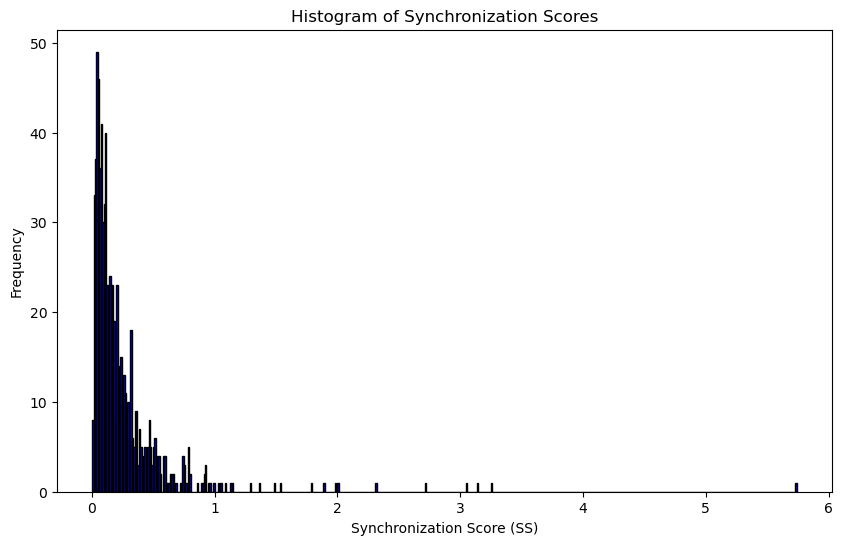

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(ss_values, bins=500, color='blue', edgecolor='black')
plt.xlabel('Synchronization Score (SS)')
plt.ylabel('Frequency')
plt.title('Histogram of Synchronization Scores')
plt.show()

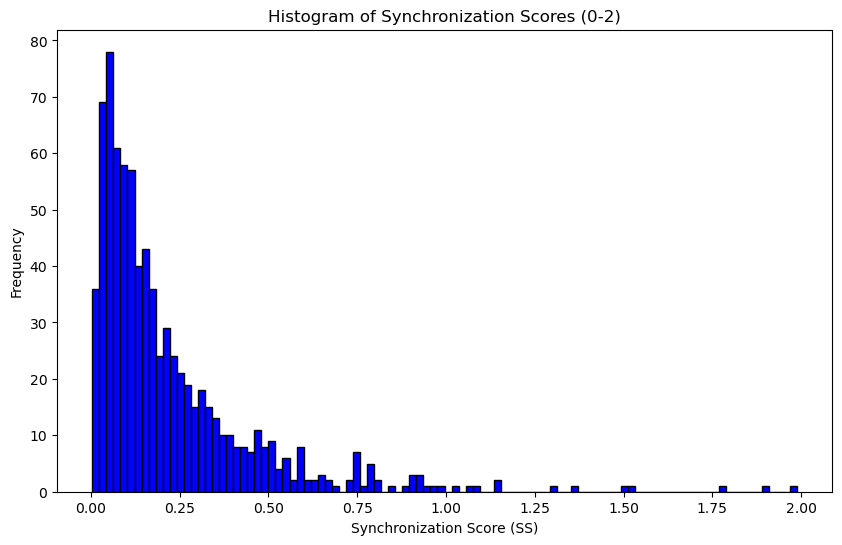

In [24]:
# Filter ss_values to include only those between 0 and 2
filtered_ss_values = [ss for ss in ss_values if 0 <= ss <= 2]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_ss_values, bins=100, color='blue', edgecolor='black')
plt.xlabel('Synchronization Score (SS)')
plt.ylabel('Frequency')
plt.title('Histogram of Synchronization Scores (0-2)')
plt.show()